# CLASSIFICATION

## 1. Imports and Setup

In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning (you will probably need to add more)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, mean_squared_error

## 2. Load the Data

#### **Wine quality - Classification**

**Dataset's description**

*Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests*.

*These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.*

*You are provided the physicochemical characteristics of the wine. You must predict the sensory perception (quality) of it (1 - 10).*

**It could be seen as a regression or a classification. We recommend to choose the other dataset if you want to perform regression, but you are welcome to attack this problem from a regression perspective too.**

Original documentation: https://archive.ics.uci.edu/dataset/186/wine+quality

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# Put them together in a single dataframe
wine_quality_df = pd.concat([X, y], axis=1)
wine_quality_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Now that we have our dataset, let's divide it into train and test splits. We will perform an EDA (Exploratory Data Analysis) on the training split.

In [3]:
from sklearn.model_selection import train_test_split
seed = 42

train_dataset, test_dataset = train_test_split(wine_quality_df, test_size=0.2, random_state=seed, stratify=wine_quality_df['quality'])


## 3. Exploratory Data Analysis

### 3.1. Initial exploration

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5197 entries, 4760 to 6420
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         5197 non-null   float64
 1   volatile_acidity      5197 non-null   float64
 2   citric_acid           5197 non-null   float64
 3   residual_sugar        5197 non-null   float64
 4   chlorides             5197 non-null   float64
 5   free_sulfur_dioxide   5197 non-null   float64
 6   total_sulfur_dioxide  5197 non-null   float64
 7   density               5197 non-null   float64
 8   pH                    5197 non-null   float64
 9   sulphates             5197 non-null   float64
 10  alcohol               5197 non-null   float64
 11  quality               5197 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 527.8 KB


We have a pretty nice dataset. In principle, all features are floating numbers and the targets are 0-9 integers. Let's see what is the quality distribution.

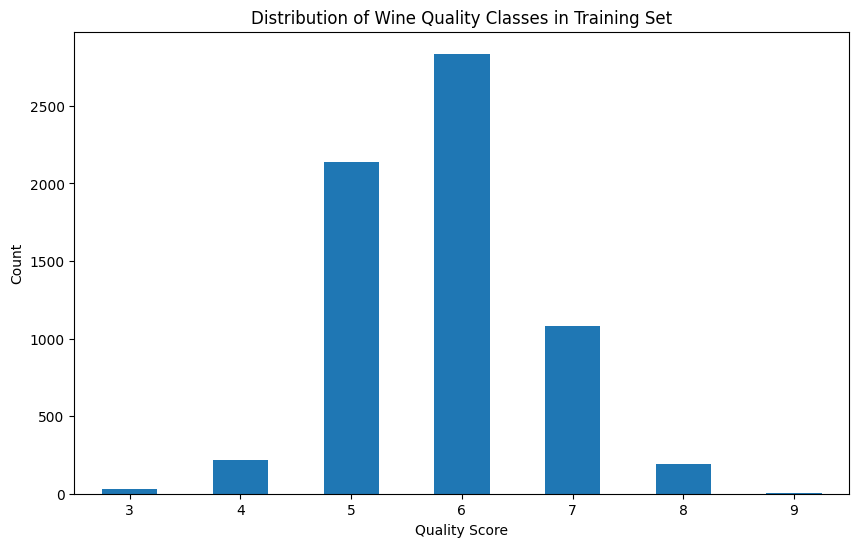


Class distribution:
Quality 3: 0.46%
Quality 4: 3.32%
Quality 5: 32.91%
Quality 6: 43.65%
Quality 7: 16.61%
Quality 8: 2.97%
Quality 9: 0.08%


In [5]:
plt.figure(figsize=(10, 6))
wine_quality_df["quality"].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Wine Quality Classes in Training Set')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Stats
print("\nClass distribution:")
class_distribution = wine_quality_df["quality"].value_counts(normalize=True).sort_index() * 100
for quality, percentage in class_distribution.items():
    print(f"Quality {quality}: {percentage:.2f}%")

The dataset is not balanced. There are way more samples of mid-quality wine and very few of high and low. This might be a problem when training. 

Let's see now if there are any NaN values.

In [6]:
print(train_dataset.isna().sum())

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Great! There are no NaN values. Let's have a look at some stats to see any possible problems.

In [7]:
train_dataset.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,7.220906,0.339995,0.318164,5.475861,0.055963,30.547912,115.964018,0.994741,3.218742,0.531728,10.475463,5.818164
std,1.286161,0.165761,0.146470,4.785528,0.034500,17.647040,56.738370,0.003011,0.160710,0.146772,1.188869,0.873126
min,4.200000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987130,2.720000,0.230000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,78.000000,0.992400,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994940,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.410000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,1.950000,14.900000,9.000000


### 3.2. Data cleaning
Everything looks normal except for the minimum value of ``citric_acid``. It is zero. Is it normal? Let's have a look at the histogram plots.

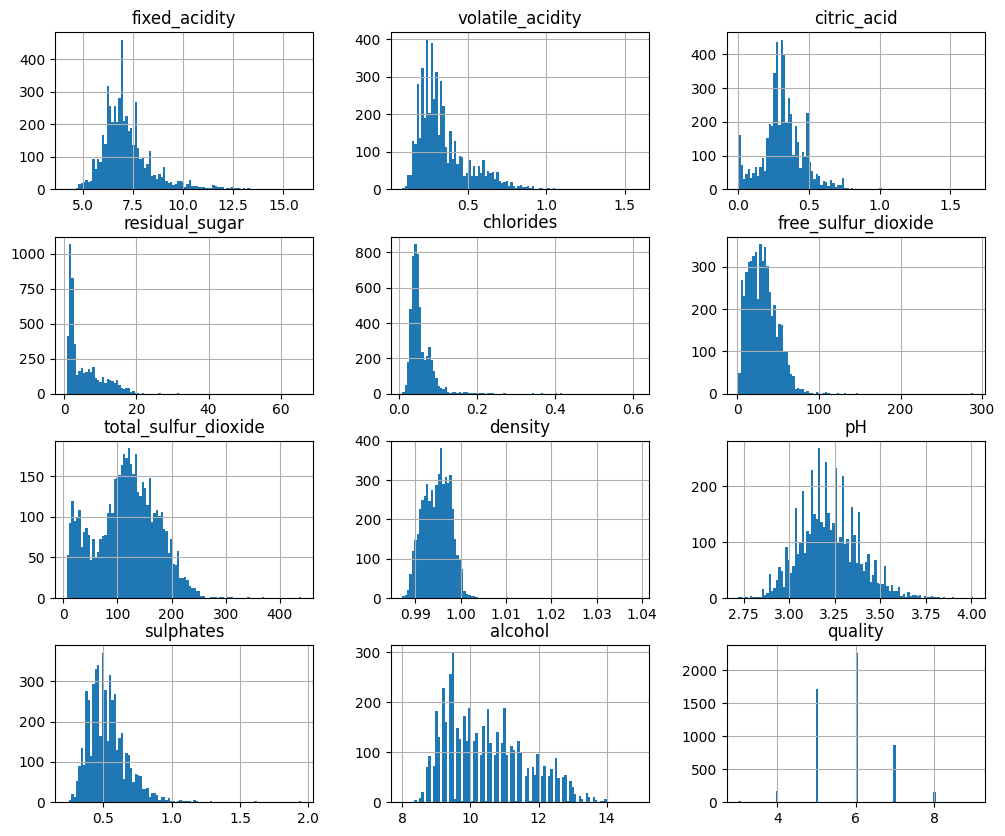

In [8]:
train_dataset.hist(bins=100, figsize=(12, 10))
plt.show()

Indeed, there is a strange peak at zero citrid acid. Either it is very common for a wine to have zero citrid acid or it is some issue of the dataset. After some Google search we find out that this is not normal. Also, citing DeepSeek...

> 🐋 DeepSeek
>
> "It's extremely rare for a finished wine to have absolutely zero citric acid, and it's not a common or typical goal in winemaking".

We have to decide what to do with these zeros. We will replace them by the mean of all non-zero values of acid citric, because this parameter has information of all the samples in the dataset. These wines will follow the most common tendency. 

In [9]:
print("Initial zero citrid_acid values: ", len(train_dataset[train_dataset['citric_acid'] == 0]))
train_dataset['citric_acid'].replace(0, train_dataset['citric_acid'].mean(), inplace=True)
print("After replacing them with the mean: ", len(train_dataset[train_dataset['citric_acid'] == 0]))

Initial zero citrid_acid values:  126
After replacing them with the mean:  0


C:\Users\angel\AppData\Local\Temp\ipykernel_6356\414712444.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_dataset['citric_acid'].replace(0, train_dataset['citric_acid'].mean(), inplace=True)


There were 126 wines with zero acid citric. Now they are replaced with the mean. Let's see how is the histogram now.

<Axes: >

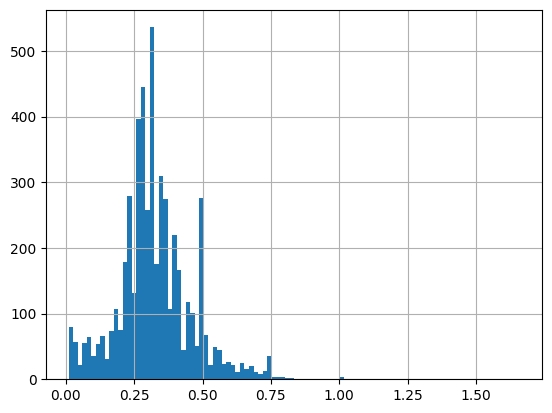

In [10]:
train_dataset["citric_acid"].hist(bins=100)

The zeros are gone and the histogram looks good now. Let's keep going with the data cleaning. We need now to remove the duplicates.

In [11]:
print(train_dataset.duplicated().sum())

793


There are 793 duplicated rows. Let's drop them.

In [12]:
print("Initial dataset length: ", len(train_dataset))
train_dataset.drop_duplicates(inplace=True)
print("Length of the dataset after dropping the duplicates: ", len(train_dataset))

Initial dataset length:  5197
Length of the dataset after dropping the duplicates:  4404


Great! Let's have a final look at the stats and let's plot the correlation matrix.

In [13]:
train_dataset.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000
mean,7.225829,0.343650,0.326662,5.098865,0.056547,30.026680,114.289282,0.994589,3.223790,0.533881,10.529363,5.799728
std,1.314082,0.168484,0.138306,4.555048,0.036114,17.626765,56.999335,0.002982,0.160337,0.146779,1.181242,0.878150
min,4.200000,0.080000,0.010000,0.600000,0.009000,1.000000,6.000000,0.987130,2.720000,0.230000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,75.000000,0.992300,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.318164,2.700000,0.047000,28.000000,116.000000,0.994740,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.600000,0.066000,41.000000,154.000000,0.996800,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,1.950000,14.900000,9.000000


<Axes: >

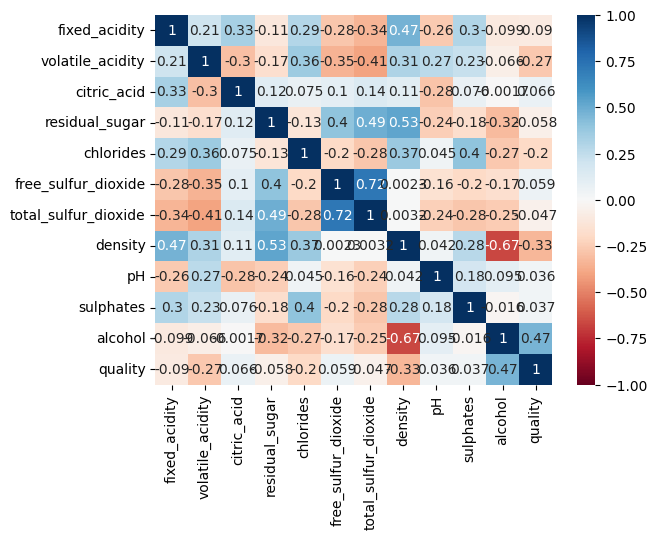

In [14]:
corr_matrix = train_dataset.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1)

### 3.3. Feature engineering

We almost finished the EDA. We just need to normalize the data to make it more friendly for the model.

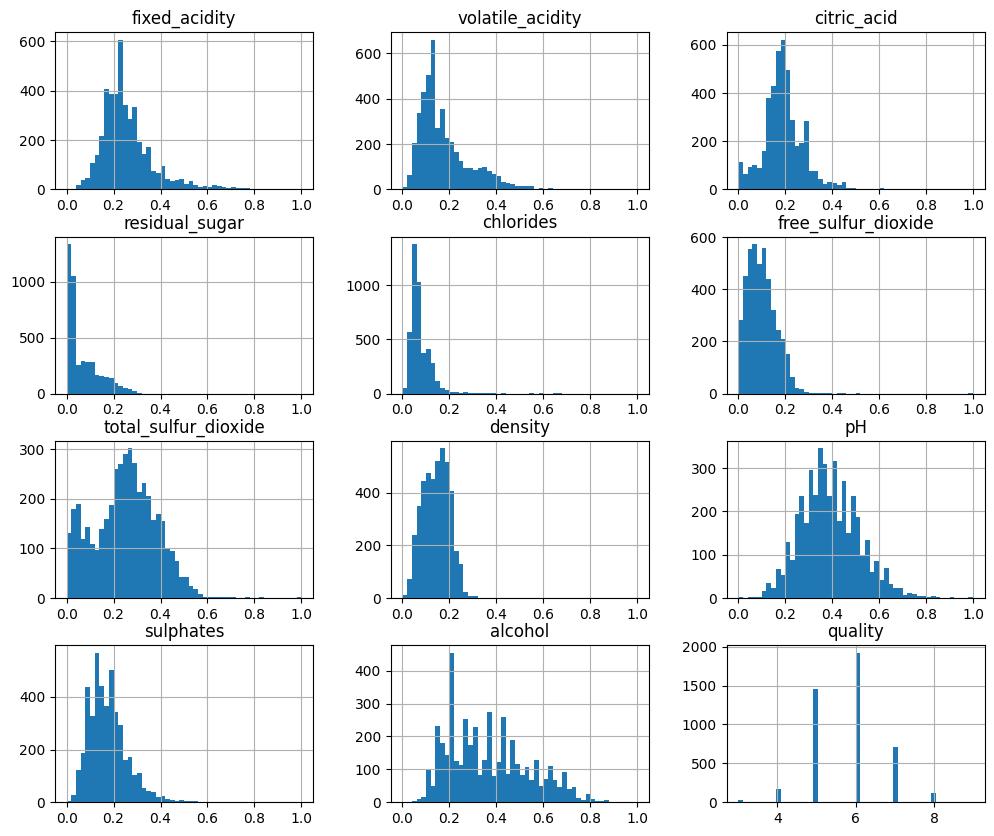

In [15]:
# We only need to normalize, because all the columns are already numerical.
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
minmaxscaler = MinMaxScaler(feature_range=(0, 1))

# Get the columns to normalize (exclude 'quality')
columns_to_normalize = train_dataset.drop(columns=['quality']).columns

# Normalize and convert back to DataFrame with column names
train_normalized = pd.DataFrame(
    minmaxscaler.fit_transform(train_dataset.drop(columns=['quality'])),
    columns=columns_to_normalize,  # <-- Preserve column names
    index=train_dataset.index
)

# Add back the 'quality' column
train_normalized["quality"] = train_dataset["quality"]

train_normalized.hist(bins=50, figsize=(12, 10))
plt.show()

We don't think there's any need to create any new feature.

## 4. Training

### 4.1. Define Features and Target

Let's define X (features) and y (target)

In [16]:
# Define X and y
X_train = train_normalized.drop(columns=['quality'])
y_train = train_normalized['quality']

### 4.2. Choose a model using cross-validation.

When doing classification, there are several available models. Here we will import some of them and evaluate their accuracy using cross-validation.


Cross-Validation Results

Evaluo en Random Forest...


c:\Users\angel\Documents\GitHub\wine-tasters-AAF\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  Accuracy: 0.5556 (+/- 0.0190)

Evaluo en Gradient Boosting...


c:\Users\angel\Documents\GitHub\wine-tasters-AAF\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  Accuracy: 0.5441 (+/- 0.0219)

Evaluo en Logistic Regression...


c:\Users\angel\Documents\GitHub\wine-tasters-AAF\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  Accuracy: 0.5450 (+/- 0.0152)

Evaluo en SVM...


c:\Users\angel\Documents\GitHub\wine-tasters-AAF\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  Accuracy: 0.5490 (+/- 0.0094)

Evaluo en K-Nearest Neighbors...


c:\Users\angel\Documents\GitHub\wine-tasters-AAF\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  Accuracy: 0.5177 (+/- 0.0221)

MODEL COMPARISON
Random Forest        | Accuracy: 0.5556
Gradient Boosting    | Accuracy: 0.5441
Logistic Regression  | Accuracy: 0.5450
SVM                  | Accuracy: 0.5490
K-Nearest Neighbors  | Accuracy: 0.5177

Best Model: Random Forest
Best Accuracy Score: 0.5556


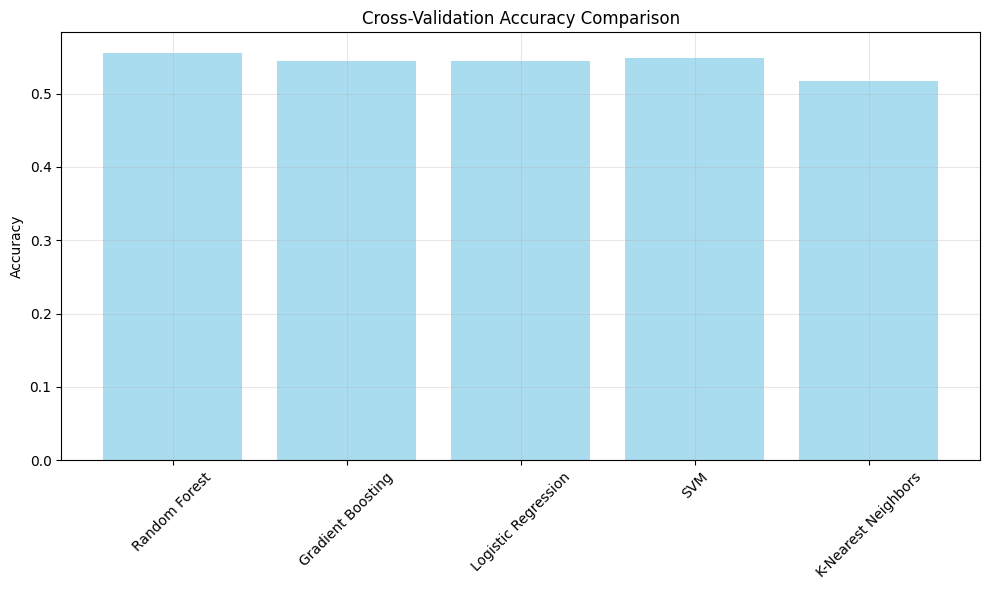

Selected model: Random Forest


In [17]:
# Import various models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=seed, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=seed, n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=seed, max_iter=1000),
    'SVM': SVC(random_state=seed),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Metrics: Accuracy
metrics = ['accuracy']

# Use stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

results = {}

print("\nCross-Validation Results")
print("=" * 60)

# Evaluate each model
for name, model in models.items():
    print(f"\nEvaluo en {name}...")
    
    # Cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='accuracy')
    accuracy_scores = cv_results['test_score']
    

    results[name] = {
        'accuracy_mean': accuracy_scores.mean(),
        'accuracy_std': accuracy_scores.std()
    }
    
 
    print(f"  Accuracy: {accuracy_scores.mean():.4f} (+/- {accuracy_scores.std() * 2:.4f})")

# Compare performances
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
for name, scores in results.items():
    print(f"{name:20} | Accuracy: {scores['accuracy_mean']:.4f}")

# Select best model based on accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy_mean'])
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy Score: {results[best_model_name]['accuracy_mean']:.4f}")

# Train the best model on training set
best_model.fit(X_train, y_train)


model_names = list(results.keys())
accuracy_means = [results[name]['accuracy_mean'] for name in model_names]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_means, alpha=0.7, color='skyblue')
plt.title('Cross-Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print(f"Selected model: {best_model_name}")

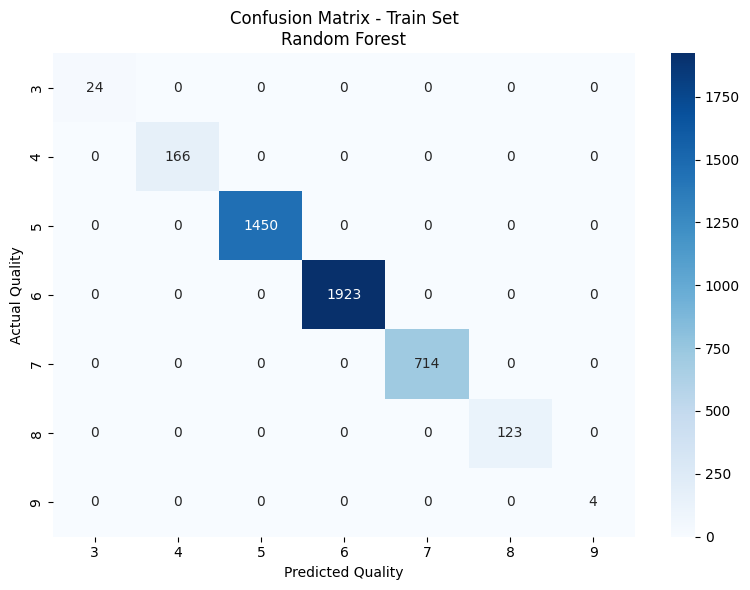

In [18]:
# Make predictions
y_pred = best_model.predict(X_train)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_train.unique()), 
            yticklabels=sorted(y_train.unique()))
plt.title(f'Confusion Matrix - Train Set\n{best_model_name}')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.tight_layout()
plt.show()

WOW! Perfect performance on train dataset.

## 5. Evaluate on test set

- Clean and do feature engineering process on test set.
- See how the model performs on the test set.


EVALUATE ON TEST SET
Original test shape and info: (1300, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 6400 to 3822
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1300 non-null   float64
 1   volatile_acidity      1300 non-null   float64
 2   citric_acid           1300 non-null   float64
 3   residual_sugar        1300 non-null   float64
 4   chlorides             1300 non-null   float64
 5   free_sulfur_dioxide   1300 non-null   float64
 6   total_sulfur_dioxide  1300 non-null   float64
 7   density               1300 non-null   float64
 8   pH                    1300 non-null   float64
 9   sulphates             1300 non-null   float64
 10  alcohol               1300 non-null   float64
 11  quality               1300 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 132.0 KB
None

Missing values in test set:
fixed_acidity           0
volat

C:\Users\angel\AppData\Local\Temp\ipykernel_6356\3917304847.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_clean['citric_acid'].replace(0, citric_acid_mean, inplace=True)
C:\Users\angel\AppData\Local\Temp\ipykernel_6356\3917304847.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean['citric_acid'].replace(0, citric_acid_m

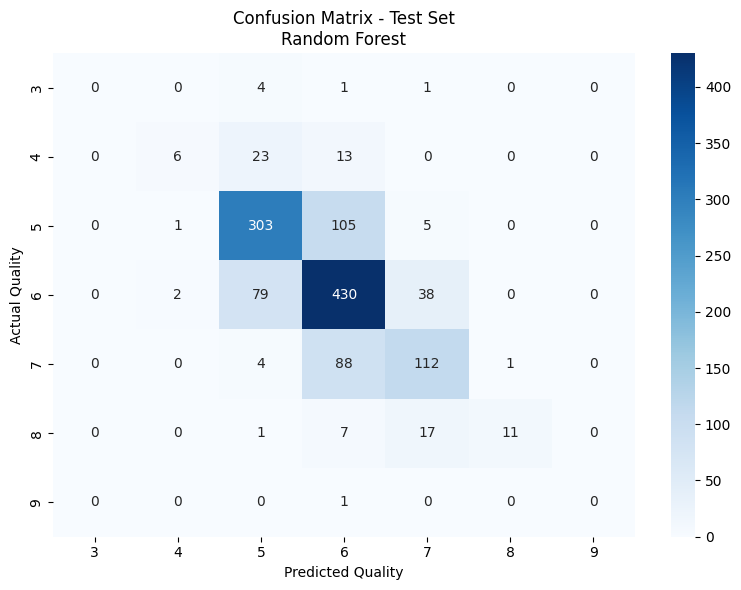

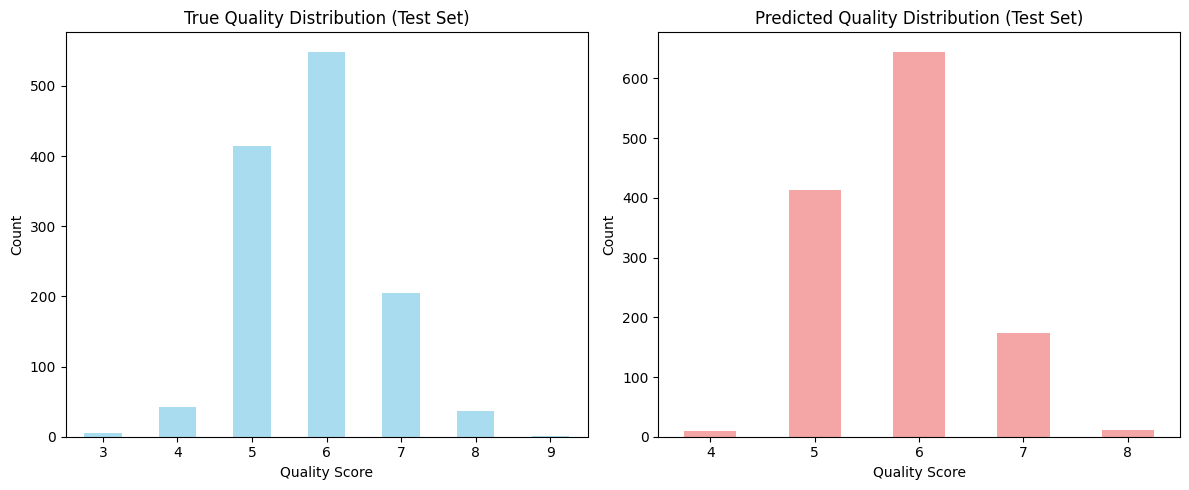


FINAL MODEL EVALUATION SUMMARY
Model: Random Forest
Training samples: 4404
Test samples: 1253
Number of features: 11
Number of classes: 7

Cross-Validation Performance:
  Accuracy: 0.5556 ± 0.0095

Test Set Performance:
  Accuracy: 0.6879

Model Analysis:
 Acceptable generalization
  Accuracy difference: 0.1323


In [19]:
print("\n" + "=" * 60)
print("EVALUATE ON TEST SET")
print("=" * 60)


# Process test set
print(f"Original test shape and info: {test_dataset.shape}")
print(test_dataset.info())

# Check for missing values
print("\nMissing values in test set:")
print(test_dataset.isna().sum())

# Check for duplicates in test
print(f"\nDuplicates in test set: {test_dataset.duplicated().sum()}")

# Remove
test_clean = test_dataset.drop_duplicates()
print(f"Test set after removing duplicates: {test_clean.shape}")

# zero values in citric_acid (same as training)
citric_acid_zeros = len(test_clean[test_clean['citric_acid'] == 0])
print(f"Zero values in citric_acid: {citric_acid_zeros}")

if citric_acid_zeros > 0:
    citric_acid_mean = train_dataset['citric_acid'].mean() 
    test_clean['citric_acid'].replace(0, citric_acid_mean, inplace=True)
    print(f"Replaced {citric_acid_zeros} zero values with training mean: {citric_acid_mean:.4f}")

# Apply normalization
test_features = test_clean.drop(columns=['quality'])
test_normalized_features = pd.DataFrame(
    minmaxscaler.transform(test_features),
    columns=test_features.columns,
    index=test_clean.index
)

test_normalized = test_normalized_features.copy()
test_normalized['quality'] = test_clean['quality']

# Remove NaN 
test_final = test_normalized.dropna()
print(f"Final test set shape after cleaning: {test_final.shape}")

#Test variables
X_test = test_final.drop(columns=['quality'])
y_test = test_final['quality']

print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")
print(f"Test target distribution:")
print(y_test.value_counts().sort_index())

#Predict
y_pred = best_model.predict(X_test)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of the test: {test_accuracy:.4f}")

# Compare with cross-validation results
cv_accuracy = results[best_model_name]['accuracy_mean']

print(f"\nComparison with Cross-Validation:")
print(f"                CV Score    Test Score   Difference")
print(f"Accuracy:       {cv_accuracy:.4f}      {test_accuracy:.4f}       {test_accuracy - cv_accuracy:+.4f}")

# Detailed classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title(f'Confusion Matrix - Test Set\n{best_model_name}')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.tight_layout()
plt.show()

# Prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
y_test.value_counts().sort_index().plot(kind='bar', alpha=0.7, color='skyblue')
plt.title('True Quality Distribution (Test Set)')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
pd.Series(y_pred).value_counts().sort_index().plot(kind='bar', alpha=0.7, color='lightcoral')
plt.title('Predicted Quality Distribution (Test Set)')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()



# Final model evaluation summary
print("\n" + "=" * 60)
print("FINAL MODEL EVALUATION SUMMARY")
print("=" * 60)
print(f"Model: {best_model_name}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {len(y_test.unique())}")
print(f"\nCross-Validation Performance:")
print(f"  Accuracy: {cv_accuracy:.4f} ± {results[best_model_name]['accuracy_std']:.4f}")
print(f"\nTest Set Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")

# Check for overfitting/underfitting
accuracy_diff = abs(test_accuracy - cv_accuracy)

print(f"\nModel Analysis:")
if accuracy_diff < 0.02:
    print("Excellent performance")
elif accuracy_diff < 0.05:
    print(" Good generalization")
elif test_accuracy < cv_accuracy - 0.05:
    print(" Possible overfitting")
else:
    print(" Acceptable generalization")

print(f"  Accuracy difference: {accuracy_diff:.4f}")

## 6. Conclusions and future work

The model performs perfectly with training data. Great! It, however, has worse performance on test data, which suggests that there is some overfitting. It, however, performs relatively good, with an accuracy of 0.688. It fails mostly in the limit cases (less than 3 and more han 8). It is somehow expected due to the lack of wine samples with that characteristics.

Nexts steps should be to try with a regression model, or with deep neural networks.